In [ ]:
!pip install torch torchvision fiftyone pillow numpy opencv-python tqdm scikit-image matplotlib --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.9 MB/s eta

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random, cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
import os
import fiftyone.zoo as foz

os.makedirs("./data", exist_ok=True)
dataset = foz.load_zoo_dataset("open-images-v6", split="validation", max_samples=1000)
print("Downloaded:", len(dataset), "images")

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v6/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-attributes-description.csv' to '/root/fiftyone/open-images-v6/validation/metadata/attributes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/validation/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpo0xfc1kq/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels-boxable.csv' to '/root/fiftyone/open-images-v6/validation/labels/classifications.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv' to '/root/fiftyone/open-images-v6/validation/labels/detections.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v6/oidv6-validation-annotations-vrd.csv' to '/root/fiftyone/open-images-v6/validation/labels/relationships.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/validation/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 1000 images


 100% |█████████████████| 1000/1000 [2.1m elapsed, 0s remaining, 7.8 files/s]       


INFO:eta.core.utils: 100% |█████████████████| 1000/1000 [2.1m elapsed, 0s remaining, 7.8 files/s]       


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |███████████████| 1000/1000 [27.9s elapsed, 0s remaining, 81.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [27.9s elapsed, 0s remaining, 81.4 samples/s]      


Dataset 'open-images-v6-validation-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation-1000' created


Downloaded: 1000 images


In [ ]:
import glob
paths = glob.glob("/root/fiftyone/open-images-v6/**/*.jpg", recursive=True)
DATA_DIR = os.path.dirname(paths[0])
print("DATA_DIR =", DATA_DIR)

DATA_DIR = /root/fiftyone/open-images-v6/validation/data


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

class ImageFolderDataset(Dataset):
    def __init__(self, root, image_size=256, max_samples=None):
        paths = []
        for ext in ("jpg","jpeg","png"):
            paths += glob.glob(os.path.join(root, f"**/*.{ext}"), recursive=True)
        if max_samples:
            paths = paths[:max_samples]
        self.paths = paths
        self.transform = T.Compose([T.Resize((image_size, image_size)), T.ToTensor()])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

In [ ]:
dataset = ImageFolderDataset(DATA_DIR, image_size=256, max_samples=1000)
print("Found", len(dataset), "images")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

Found 1000 images


In [ ]:
def conv_block(in_c, out_c, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, k, s, p),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

In [ ]:
class UNetHiding(nn.Module):
    def __init__(self, base=64):
        super().__init__()
        self.enc1 = nn.Sequential(conv_block(3, base), conv_block(base, base))
        self.pool = nn.AvgPool2d(2)
        self.enc2 = nn.Sequential(conv_block(base, base*2), conv_block(base*2, base*2))
        self.enc3 = nn.Sequential(conv_block(base*2, base*4), conv_block(base*4, base*4))
        self.bott = nn.Sequential(conv_block(base*4, base*8), conv_block(base*8, base*8))
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.dec3 = nn.Sequential(conv_block(base*8, base*4), conv_block(base*4, base*4))
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec2 = nn.Sequential(conv_block(base*4, base*2), conv_block(base*2, base*2))
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.dec1 = nn.Sequential(conv_block(base*2, base), conv_block(base, base))
        self.out = nn.Sequential(nn.Conv2d(base, 3, 1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bott(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up3(b), e3],1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2],1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1],1))
        return self.out(d1)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.net = nn.Sequential(conv_block(ch,ch), conv_block(ch,ch))
    def forward(self,x): return F.relu(x + self.net(x))

In [ ]:
class RevealingNet(nn.Module):
    def __init__(self, base=64, n_res=5):
        super().__init__()
        self.down1 = conv_block(3, base)
        self.down2 = conv_block(base, base*2)
        self.res   = nn.Sequential(*[ResidualBlock(base*2) for _ in range(n_res)])
        self.up    = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.out   = nn.Sequential(conv_block(base,3), nn.Sigmoid())
    def forward(self,x):
        d1 = self.down1(x)
        d2 = self.down2(F.avg_pool2d(d1,2))
        r  = self.res(d2)
        u  = self.up(r)
        return self.out(u)

In [ ]:
class AttackModule:
    def __init__(self): pass

    def distort(self, img):
        arr = (img.detach().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        if random.random() < 0.4:
            arr = cv2.GaussianBlur(arr, (5, 5), 0)
        if random.random() < 0.4:
            q = random.randint(60, 95)
            _, enc = cv2.imencode(
                ".jpg",
                cv2.cvtColor(arr, cv2.COLOR_RGB2BGR),
                [int(cv2.IMWRITE_JPEG_QUALITY), q],
            )
            arr = cv2.cvtColor(cv2.imdecode(enc, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        return torch.from_numpy(arr.astype(np.float32) / 255.0).permute(2, 0, 1)

    def tamper_local(self, img):
        B, C, H, W = img.shape
        out = img.clone()
        mask = torch.zeros(B, 1, H, W)
        for i in range(B):
            x, y = random.randint(0, W // 2), random.randint(0, H // 2)
            w, h = random.randint(W // 8, W // 4), random.randint(H // 8, H // 4)
            out[i, :, y:y+h, x:x+w] = torch.rand_like(out[i, :, y:y+h, x:x+w])
            mask[i, 0, y:y+h, x:x+w] = 1.0
        return out, mask

    def __call__(self, container):
        distorted = torch.stack([self.distort(c) for c in container])
        return self.tamper_local(distorted)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
hider, revealer = UNetHiding().to(device), RevealingNet().to(device)
opt=torch.optim.Adam(list(hider.parameters())+list(revealer.parameters()),lr=1e-4)
mse=nn.MSELoss()
attack=AttackModule()

In [ ]:
def psnr(a,b):
    mse_val=torch.mean((a-b)**2)
    return 20*torch.log10(1.0/torch.sqrt(mse_val))

loss_log,psnr_log,ssim_log,ious=[],[],[],[]

In [ ]:
for epoch in range(3):  # increase for better results
    hider.train(); revealer.train(); run_loss=0
    for imgs in tqdm(loader,desc=f"Epoch {epoch+1}"):
        covers=imgs.to(device)
        secrets=covers[torch.randperm(len(covers))]
        wm=hider(secrets)
        container=torch.clamp(covers+0.5*(wm+1),0,1)
        tampered,mask=attack(container); tampered,mask=tampered.to(device),mask.to(device)
        retrieved=revealer(tampered)
        masked_secret=secrets*(1-mask)
        loss_hide=mse(container,covers)
        loss_reveal=mse(retrieved*(1-mask),masked_secret)
        loss=loss_hide+0.75*loss_reveal
        opt.zero_grad(); loss.backward(); opt.step()
        run_loss+=loss.item()
    avg_loss=run_loss/len(loader); loss_log.append(avg_loss)
    # quick evaluation
    hider.eval(); revealer.eval()
    with torch.no_grad():
        imgs=next(iter(loader)).to(device)
        covers=imgs; secrets=covers[torch.randperm(len(covers))]
        wm=hider(secrets)
        container=torch.clamp(covers+0.5*(wm+1),0,1)
        tampered,mask=attack(container); tampered,mask=tampered.to(device),mask.to(device)
        retrieved=revealer(tampered)
        psnr_val=psnr(retrieved,secrets).item()
        ssim_val=ssim(retrieved[0].permute(1,2,0).cpu().numpy(),
                      secrets[0].permute(1,2,0).cpu().numpy(),
                      channel_axis=2,data_range=1.0)
        diff=torch.mean(torch.abs(retrieved-secrets),1,True)
        pred=(diff>0.05).float()
        iou=((pred*mask).sum()/((pred+mask>0).float().sum()+1e-8)).item()
        psnr_log.append(psnr_val); ssim_log.append(ssim_val); ious.append(iou)
    print(f"Loss={avg_loss:.4f} | PSNR={psnr_val:.2f} dB | SSIM={ssim_val:.3f} | IoU={iou:.3f}")

Epoch 1: 100%|██████████| 250/250 [01:23<00:00,  3.00it/s]


Loss=0.1064 | PSNR=10.53 dB | SSIM=0.277 | IoU=0.034


Epoch 2: 100%|██████████| 250/250 [01:24<00:00,  2.98it/s]


Loss=0.0691 | PSNR=11.36 dB | SSIM=0.264 | IoU=0.050


Epoch 3: 100%|██████████| 250/250 [01:26<00:00,  2.89it/s]


Loss=0.0632 | PSNR=9.47 dB | SSIM=0.142 | IoU=0.035


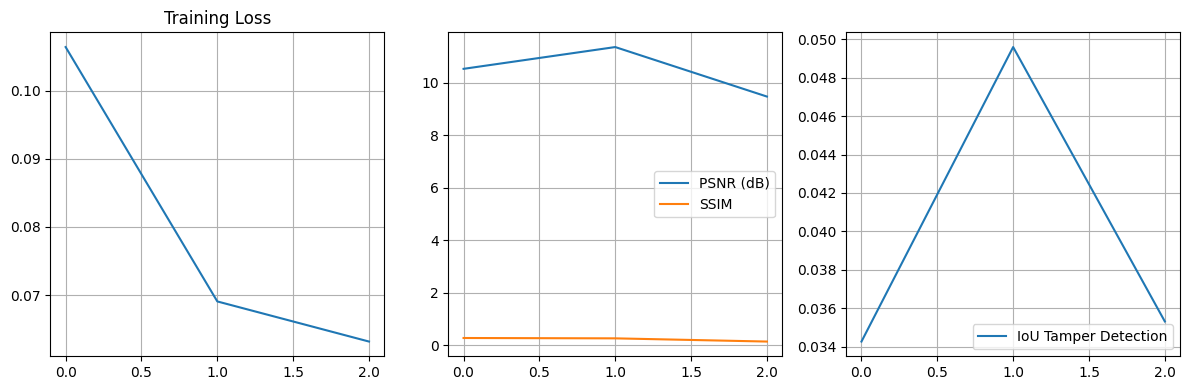

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(loss_log); plt.title("Training Loss"); plt.grid()
plt.subplot(1,3,2); plt.plot(psnr_log,label="PSNR (dB)"); plt.plot(ssim_log,label="SSIM"); plt.legend(); plt.grid()
plt.subplot(1,3,3); plt.plot(ious,label="IoU Tamper Detection"); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

In [ ]:
idx=random.randint(0,3)
cover=covers[idx].cpu().permute(1,2,0)
container=container[idx].cpu().permute(1,2,0)
tam=tampered[idx].cpu().permute(1,2,0)
retr=retrieved[idx].cpu().permute(1,2,0)
mask_img=mask[idx,0].cpu()

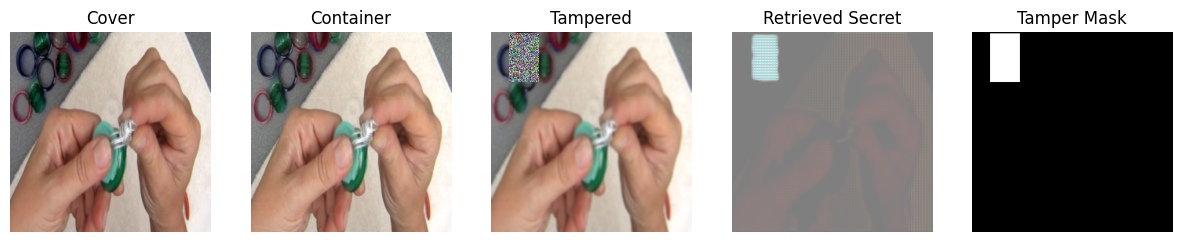

In [ ]:
fig,axs=plt.subplots(1,5,figsize=(15,4))
for ax,img,title in zip(axs,[cover,container,tam,retr,mask_img],
                        ["Cover","Container","Tampered","Retrieved Secret","Tamper Mask"]):
    ax.imshow(img if img.ndim==3 else img,cmap='gray'); ax.set_title(title); ax.axis("off")
plt.show()

In [ ]:
print(f"Final metrics: PSNR ≈ {psnr_log[-1]:.2f} dB | SSIM ≈ {ssim_log[-1]:.3f} | IoU ≈ {ious[-1]:.3f}")

Final metrics: PSNR ≈ 9.47 dB | SSIM ≈ 0.142 | IoU ≈ 0.035
